# Exploration of results from Bayesian modelling

We have run a hierarchical MCMC model to estimate galaxy pitch angle from clustered spiral arms obtained through the _Galaxy Builder_ citizen science project.

<img src="plots_n109d1000t500/prediction_comparison.png" width=800 style="margin:20px auto">

In [1]:
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import pymc3 as pm
from tqdm import tqdm
import scipy.stats as st
import warnings

warnings.simplefilter('ignore', UserWarning)

Could not import matplotlib.animation 'ascii' codec can't decode byte 0xc2 in position 90: ordinal not in range(128)


In [2]:
INPUT_FILE = 'n109d1000t500.pickle'

In [3]:
res = pd.read_pickle(INPUT_FILE)
bhsm = res['model']
trace = res['trace']

In [4]:
gal_pa_samples = pd.DataFrame(
    trace['phi_gal'].T,
    index=bhsm.galaxies.index
)

In [5]:
pa_expectation = gal_pa_samples.mean(axis=1)
pa_std = gal_pa_samples.std(axis=1)

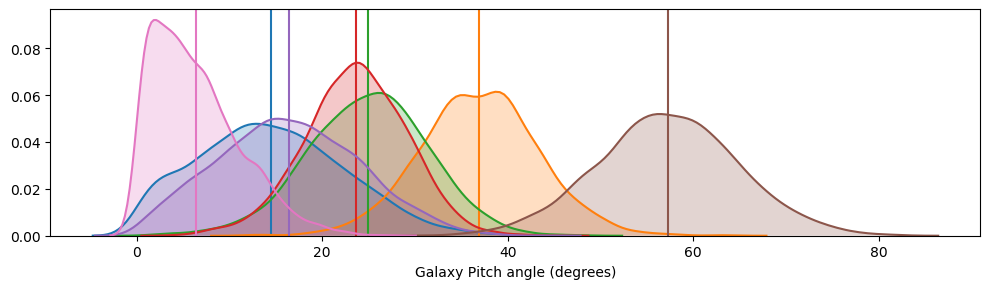

In [6]:
plt.figure(figsize=(12, 3), dpi=100)
sample = pa_expectation.sample(5)
for i, idx in enumerate(sample.index.values.tolist() + [pa_expectation.idxmax(), pa_expectation.idxmin()]):
    sns.kdeplot((gal_pa_samples.loc[idx]), shade=True, color=f'C{i}')
    plt.axvline(gal_pa_samples.loc[idx].mean(), color=f'C{i}')
# i = (gal_pa_samples.idxmax(), gal_pa_samples.idxmin())
plt.xlabel('Galaxy Pitch angle (degrees)')
plt.gca().get_legend().remove()
plt.savefig('plots/gal_pa_kde_sample.png', bbox_inches='tight')

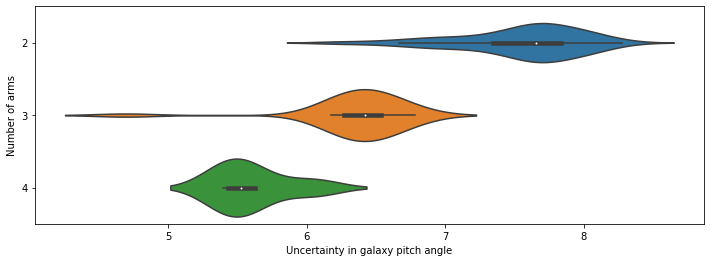

In [7]:
plt.figure(figsize=(12, 4))
sns.violinplot(pa_std, bhsm.galaxies.apply(len), orient='horizontal')
plt.xlabel('Uncertainty in galaxy pitch angle')
plt.ylabel('Number of arms')
plt.savefig('plots/error_vs_n_arms.png', bbox_inches='tight')

## Comparison to length-weighted pitch angles

Let's get some values for the length-weighted pitch angle of our galaxies:

In [8]:
# sample extraction
galaxies_df = pd.read_pickle('lib/merged_arms.pickle')
# keep only galaxies with one arm or more
galaxies_df = galaxies_df[galaxies_df.notna().any(axis=1)]
pa_lw_mean = galaxies_df.apply(
    lambda row: row['pipeline'].get_pitch_angle(row.drop('pipeline').dropna().values)[0],
    axis=1
).reindex_like(galaxies_df)

def get_err(row):
    return row.dropna()\
      .drop('pipeline')\
      .apply(lambda arm: arm.pa)\
      .std()
pa_lw_err = galaxies_df.apply(get_err, axis=1).reindex_like(galaxies_df).fillna(0)
print('Total number of galaxies:', len(pa_lw_err))

Total number of galaxies: 198


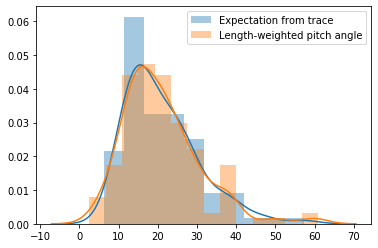

In [9]:

sns.distplot(pa_expectation, label='Expectation from trace')
sns.distplot(pa_lw_mean.dropna(), label='Length-weighted pitch angle')
plt.legend()

In [10]:
lw_df = pd.concat((
    pa_lw_mean.dropna().rename('lw'),
    pa_lw_err.rename('lw_err'),
    pa_expectation.rename('E'),
    pa_std.rename('E_err'),
    bhsm.galaxies.apply(len).rename('n'),
), axis=1).dropna()

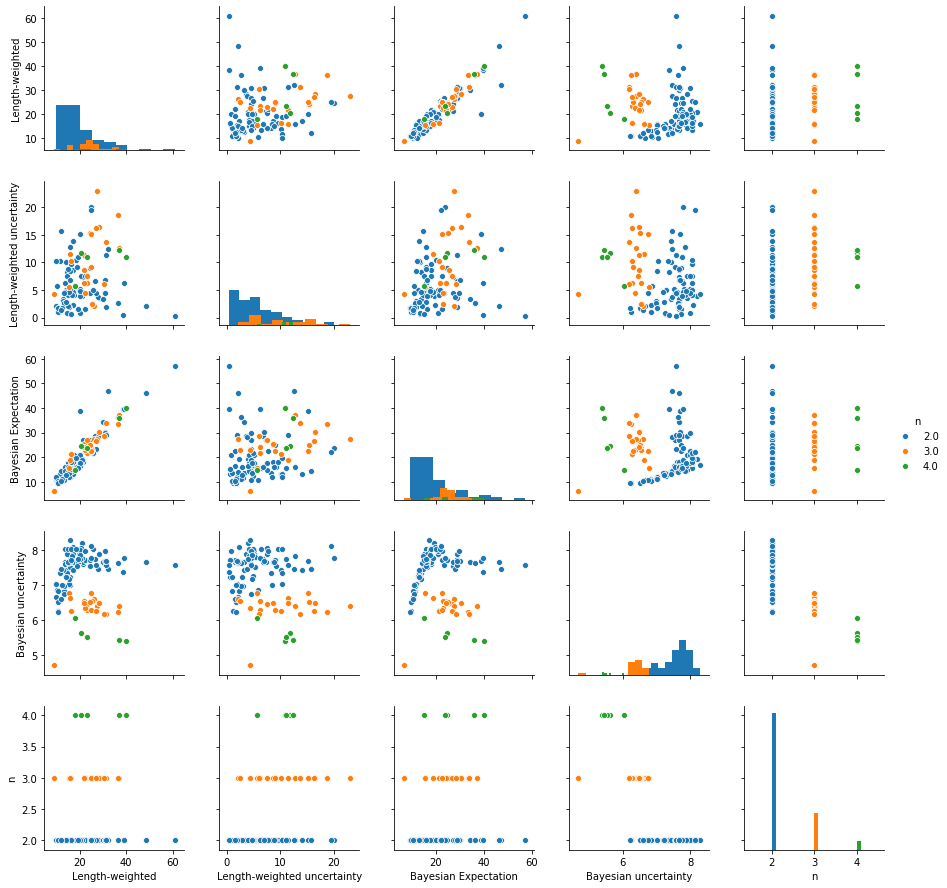

In [11]:
sns.pairplot(
    lw_df.rename(columns=dict(
        lw='Length-weighted',
        lw_err='Length-weighted uncertainty',
        E='Bayesian Expectation',
        E_err='Bayesian uncertainty',
    )),
    hue='n', diag_kind='hist'
)

Text(0, 0.5, 'Expectation from Bayesian modelling')

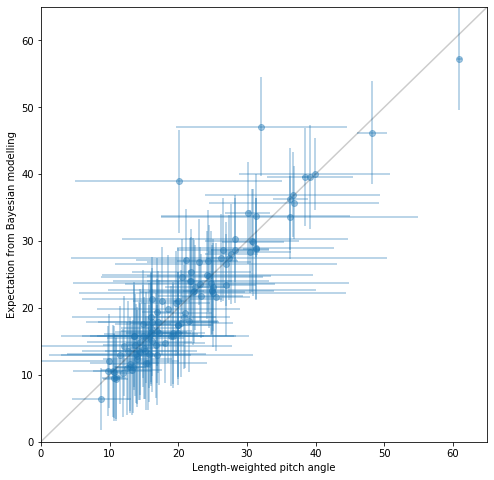

In [12]:
plt.figure(figsize=(8, 8))
plt.errorbar(
    lw_df['lw'], lw_df['E'],
    xerr=lw_df['lw_err'], yerr=lw_df['E_err'],
    fmt='o', alpha=0.4
)
plt.plot((0, 90), (0, 90), c='k', alpha=0.2)
plt.xlim(0, 65)
plt.ylim(0, 65)
plt.xlabel('Length-weighted pitch angle')
plt.ylabel('Expectation from Bayesian modelling')

The values are very consistent, as would be expected. However the measure of error generally used with length-weighted pitch angle measurement (sample error of arm segment pitch angle), does not provide as robust a measurement as the error in the posterior we obtain for $\phi_\mathrm{gal}$.

## Comparison to GZ2 and Hart (2017)

In [13]:
gz2_spiral_data = pd.read_csv('lib/gz2_spiral_data.csv', index_col=0)

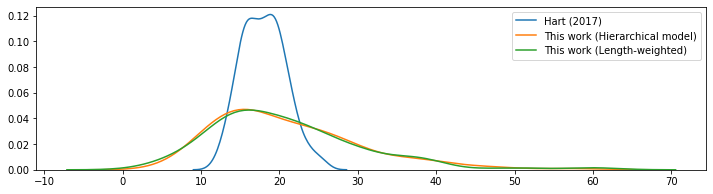

In [14]:
plt.figure(figsize=(12, 3))
sns.kdeplot(gz2_spiral_data['hart_pa'].dropna(), label='Hart (2017)')
sns.kdeplot(pa_expectation, label='This work (Hierarchical model)')
sns.kdeplot(pa_lw_mean.dropna(), label='This work (Length-weighted)')

In [15]:
def set_color_by_correlation(row, cmap=cm.get_cmap('RdYlGn', 12)):
    values = (np.array([cmap((value + 1) / 2) for value in row])  * [256, 256, 256, 1]).astype(int)
    return [f'background-color: rgba{tuple(value.tolist())}' for value in values]

,GZ2 Winding coefficient,Hart (2017),Expectation,Length-weighted
GZ2 Winding coefficient,1,0.957395,0.521139,0.486516
Hart (2017),0.957395,1,0.497078,0.436829
Expectation,0.521139,0.497078,1,0.938762
Length-weighted,0.486516,0.436829,0.938762,1


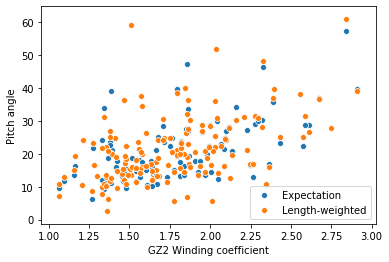

In [16]:
sns.scatterplot(gz2_spiral_data['winding'], pa_expectation, label='Expectation')
sns.scatterplot(gz2_spiral_data['winding'], pa_lw_mean, label='Length-weighted')
plt.xlabel('GZ2 Winding coefficient')
plt.ylabel('Pitch angle')
pd.concat((
    gz2_spiral_data['winding'].rename('GZ2 Winding coefficient'),
    gz2_spiral_data['hart_pa'].rename('Hart (2017)'),
    pa_expectation.rename('Expectation'),
    pa_lw_mean.rename('Length-weighted'),
), axis=1).corr().style.apply(set_color_by_correlation)

Text(0, 0.5, 'This work')

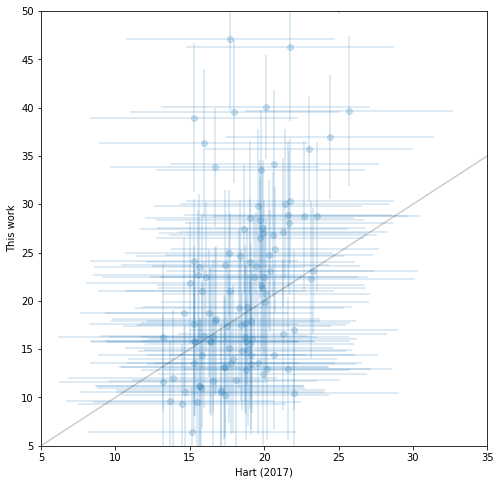

In [17]:
plt.figure(figsize=(8, 8))
df = pd.concat((gz2_spiral_data['hart_pa'], pa_expectation.rename('pa'), pa_std.rename('err')), axis=1).dropna()
plt.errorbar(df['hart_pa'], df['pa'], xerr=7, yerr=df['err'], fmt='o', alpha=0.2)
l = np.stack((plt.ylim(), plt.xlim()))
plt.plot((0, 90), (0, 90), c='k', alpha=0.2)
plt.xlim(5, 35)
plt.ylim(5, 50)
plt.xlabel('Hart (2017)')
plt.ylabel('This work')

## Potential source distributions

[Pringle & Dobbs (2019)](https://arxiv.org/pdf/1909.10291.pdf) propose that for a simple model of spiral awm winding, galaxy pitch angle should be uniform in $\cot\phi$ between some limits. We examine this possibility using repetitions of the [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) and [Anderson-Darling](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test) tests for different realizations of the posterior distribution of galaxy pitch angle (which we will refer to as _marginalized tests_). We also invsetigate the Beta distribution and Truncated Normal distribution as possible source distributions.

In [18]:
def cot(phi):
    return 1 / np.tan(np.radians(phi))

def acot(a):
    return np.degrees(np.arctan(1 / a))

def truncnorm(loc, scale, lower=0, upper=90):
    return st.truncnorm(
        (lower - loc) / scale, (upper - loc) / scale,
        loc=loc, scale=scale
    )

def truncnorm_nnlf(loc, scale, data, lower=0, upper=90):
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return st.truncnorm.nnlf((a, b, loc, scale), data)

In [67]:
LOWER_COT_BOUND = 1.19
UPPER_COT_BOUND = cot(10)

lower_phi_bound = acot(UPPER_COT_BOUND)
upper_phi_bound = acot(LOWER_COT_BOUND)
print(f'{LOWER_COT_BOUND:.2f} < cot(ɸ) < {UPPER_COT_BOUND:.2f}')
print(f'{lower_phi_bound:.2f} < ɸ < {upper_phi_bound:.2f}')

1.19 < cot(ɸ) < 5.67
10.00 < ɸ < 40.04


Perform the _Marginalized_ tests for the different distributions

In [68]:
# Test against cot-uniform
ks = pd.Series([], name='ks_test_result')
anderson = pd.Series([], name='anderson_test_result')
cot_target_dist = st.uniform(LOWER_COT_BOUND, UPPER_COT_BOUND - LOWER_COT_BOUND)
comparison_dataset = cot_target_dist.rvs(10000)

# Test against scaled beta
ks_beta = pd.Series([], name='ks_test_result')
anderson_beta = pd.Series([], name='anderson_test_result')
betas = []

# Test against truncated normal
ks_truncnorm = pd.Series([], name='ks_test_result')
anderson_truncnorm = pd.Series([], name='anderson_test_result')
truncnorms = []

with tqdm(range(trace['phi_gal'].shape[0])) as bar:
    for i in bar:
        phi_gal_est = trace['phi_gal'][i]
        
        cot_mask = (cot(phi_gal_est) > LOWER_COT_BOUND) & (cot(phi_gal_est) < UPPER_COT_BOUND)
        anderson[i] = st.anderson_ksamp((
            cot(phi_gal_est[cot_mask]),
            comparison_dataset,
        ))
        ks[i] = st.kstest(
            cot(phi_gal_est[cot_mask]),
            cot_target_dist.cdf,
        )
        
        beta_fit = st.beta(*st.beta.fit(phi_gal_est, fscale=90, floc=0))
        betas.append(beta_fit)
        anderson_beta[i] = st.anderson_ksamp((
            phi_gal_est,
            beta_fit.rvs(10000),
        ))
        ks_beta[i] = st.kstest(
            phi_gal_est,
            beta_fit.cdf,
        )

        truncnorm_fit = truncnorm(
            *minimize(lambda p: truncnorm_nnlf(*p, phi_gal_est), (10, 10))['x']
        )
        truncnorms.append(truncnorm_fit)
        anderson_truncnorm[i] = st.anderson_ksamp((
            phi_gal_est,
            truncnorm_fit.rvs(10000),
        ))
        ks_truncnorm[i] = st.kstest(
            phi_gal_est,
            truncnorm_fit.cdf,
        )

ks = ks.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson = anderson.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

ks_beta = ks_beta.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson_beta = anderson_beta.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

ks_truncnorm = ks_truncnorm.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson_truncnorm = anderson_truncnorm.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

100%|██████████| 4000/4000 [03:16<00:00, 20.40it/s]


Cheeky helper function to do custom logarithmic histogramming:

In [69]:
def do_log_hist(vals, *args, **kwargs):
    cumulative = kwargs.pop('cumulative', False)
    counts, bins = np.histogram(np.log10(vals), bins='scott', *args, **kwargs)
    if cumulative:
        counts = np.cumsum(counts / counts.sum())
    line = plt.step(10**bins, np.concatenate(([0], counts)), color='C1')[0]
    plt.fill_between(10**np.repeat(bins, 2)[1:-1], np.repeat(counts, 2), color='C1', alpha=0.2)
    plt.xscale('log')

Thresholds:
       25%: 0.33, reject 100% of the time
       10%: 1.23, reject 100% of the time
        5%: 1.96, reject 100% of the time
      2.5%: 2.72, reject 100% of the time
        1%: 3.75, reject 100% of the time


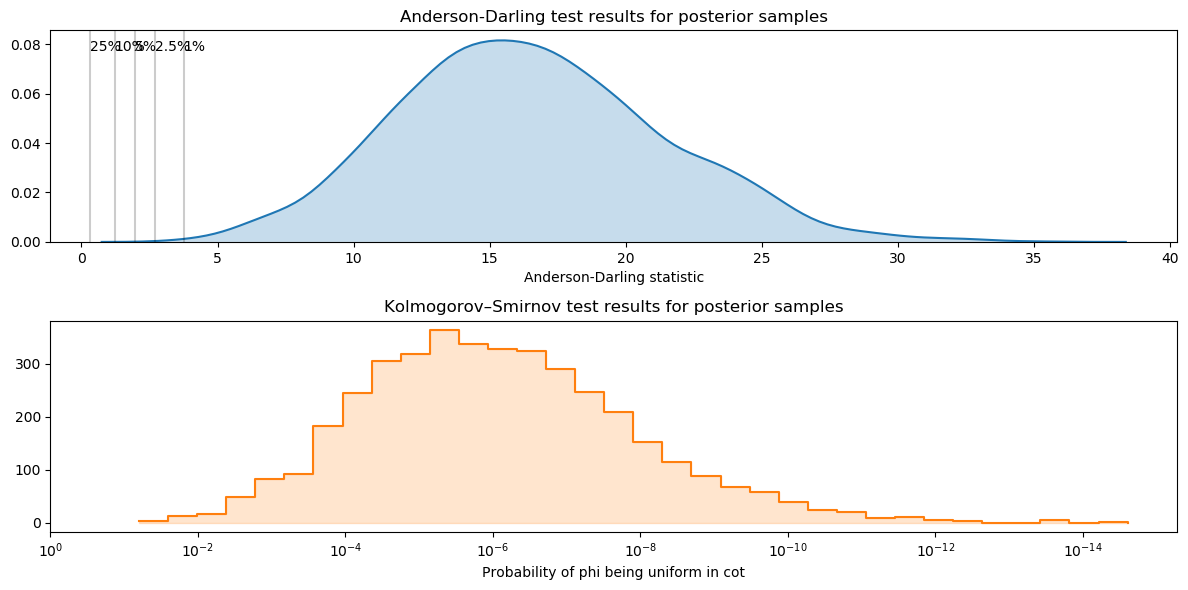

In [70]:
f, ax = plt.subplots(nrows=2, figsize=(12, 6), dpi=100)

plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson['value'], label='', shade=True)
print('Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%'),
    np.stack(anderson['levels'].values).mean(axis=0)
):
    freq = (anderson['value'] >= j).sum() / len(anderson['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.sca(ax[1])
plt.title(r'Kolmogorov–Smirnov test results for posterior samples')
do_log_hist(ks['p'])
plt.xlim(left=1E0, right=plt.xlim()[0])
plt.xlabel(r'Probability of phi being uniform in cot')
plt.tight_layout()
plt.savefig('plots/cot_uniform_marginalized_tests.pdf', bbox_inches='tight')

Therefore we cannot unilaterally reject the hypothesis that the galaxy pitch angles for our sample are uniformly distributed in $\cot$ between the limits present in [Pringle & Dobbs (2019)](https://arxiv.org/pdf/1909.10291.pdf).

Interestingly, the observed pitch angles could definitely be drawn from a Beta distribution:

$$\phi_\mathrm{gal} \sim 90 \times \mathrm{Beta}(a, b)$$

Thresholds:
       25%: 0.33, reject 19% of the time
       10%: 1.23, reject 4% of the time
        5%: 1.96, reject 1% of the time
      2.5%: 2.72, reject 0% of the time
        1%: 3.75, reject 0% of the time


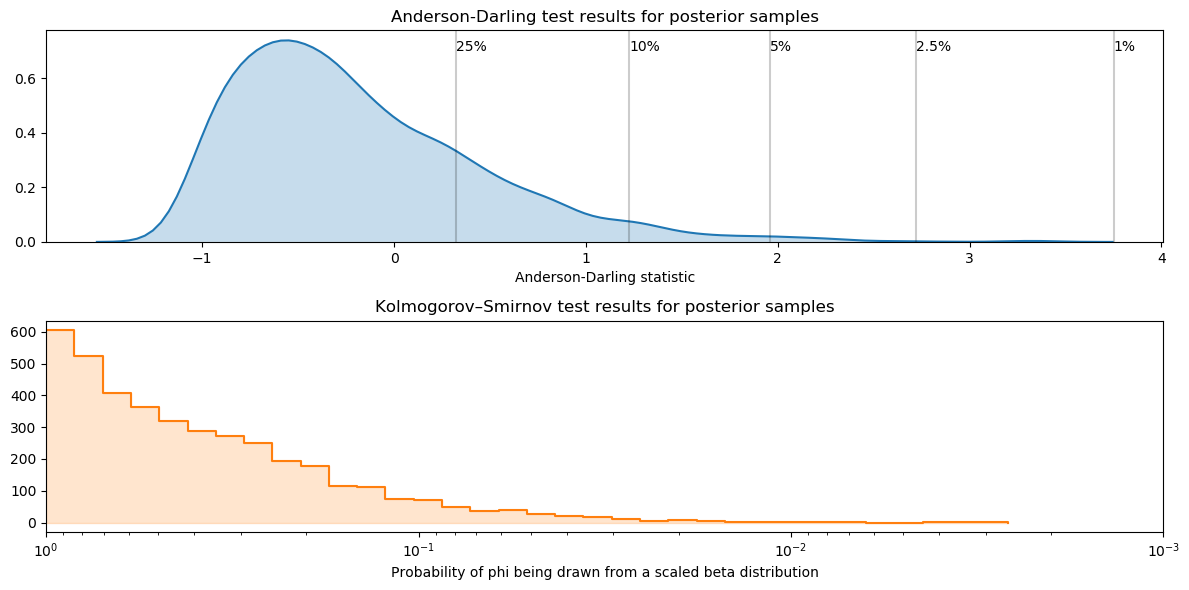

In [23]:
f, ax = plt.subplots(nrows=2, figsize=(12, 6), dpi=100)

plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson_beta['value'], label='', shade=True)
print('Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%'),
    np.stack(anderson_beta['levels'].values).mean(axis=0)
):
    freq = (anderson_beta['value'] >= j).sum() / len(anderson['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.sca(ax[1])
plt.title(r'Kolmogorov–Smirnov test results for posterior samples')
# sns.distplot(np.log10(ks_beta['p']), label='', kde=False, norm_hist=True, color='C1')
# plt.xticks(*gen_ticks_labels(-3, 0, 1))
do_log_hist(ks_beta['p'])
plt.xlim(1, 1E-3)
plt.xlabel(r'Probability of phi being drawn from a scaled beta distribution')
plt.tight_layout()
plt.savefig('plots/beta_marginalized_tests.pdf', bbox_inches='tight')

A normal distribution truncated between 0 and 90 is also a good candidate:

Thresholds:
       25%: 0.33, reject 0% of the time
       10%: 1.23, reject 0% of the time
        5%: 1.96, reject 0% of the time
      2.5%: 2.72, reject 0% of the time
        1%: 3.75, reject 0% of the time


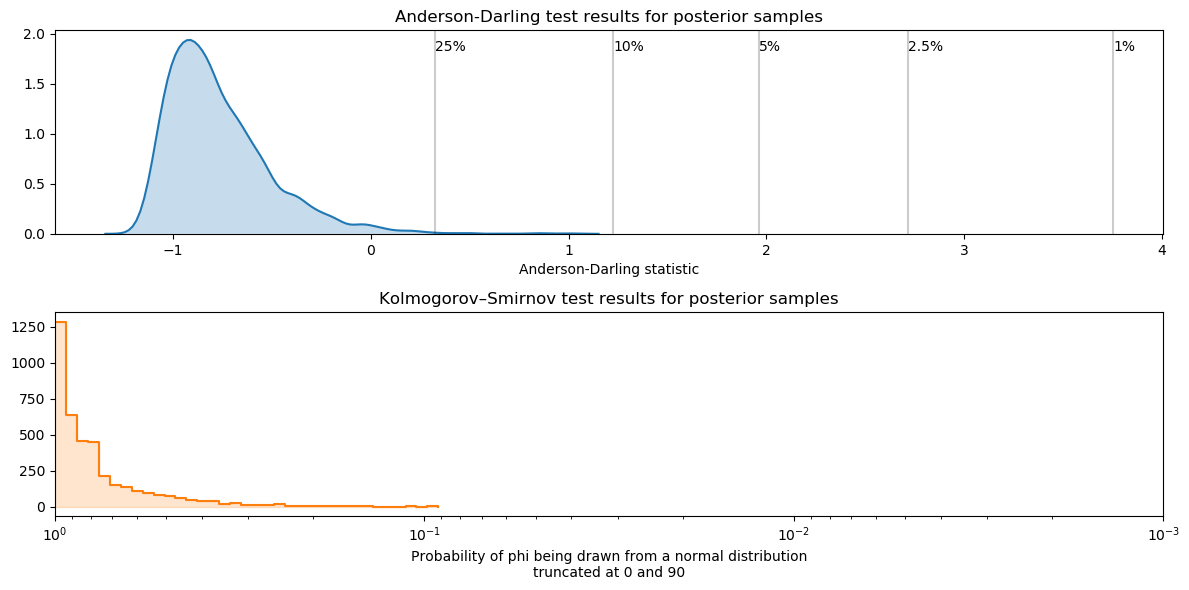

In [24]:
f, ax = plt.subplots(nrows=2, figsize=(12, 6), dpi=100)

plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson_truncnorm['value'], label='', shade=True)
print('Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%'),
    np.stack(anderson_truncnorm['levels'].values).mean(axis=0)
):
    freq = (anderson_truncnorm['value'] >= j).sum() / len(anderson['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.sca(ax[1])
plt.title(r'Kolmogorov–Smirnov test results for posterior samples')
do_log_hist(ks_truncnorm['p'])
plt.xlim(1, 1E-3)
plt.xlabel('Probability of phi being drawn from a normal distribution\ntruncated at 0 and 90')
plt.tight_layout()
plt.savefig('plots/truncnorm_marginalized_tests.pdf', bbox_inches='tight')

We illustrate the different potential source distributions using their fitted values for each draw (apart from the cot-uniform, which for convenience is a histogram of points sampled from the distribution)

In [25]:
_x = np.linspace(0, 90, 1000)
truncnorm_evals = np.array([t.pdf(_x) for t in truncnorms])
beta_evals = np.array([b.pdf(_x) for b in betas])

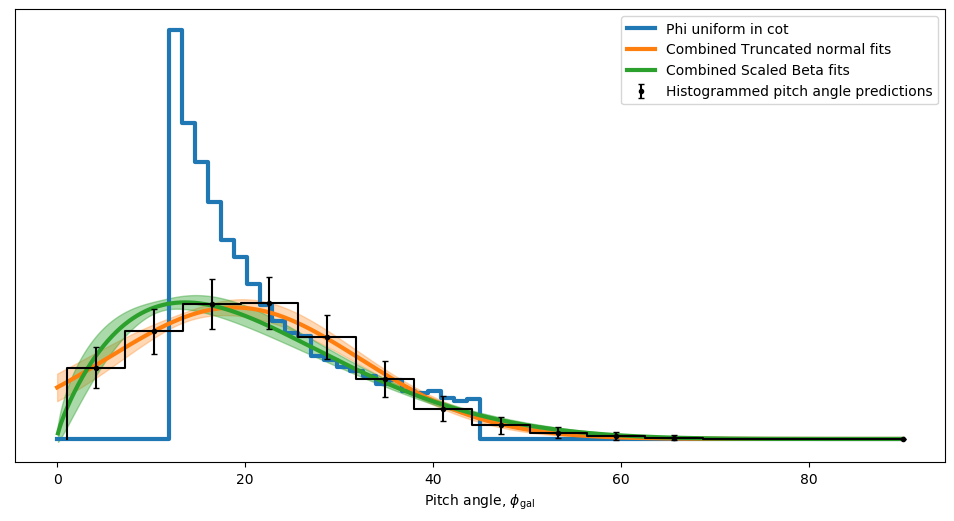

In [51]:
idx = np.random.choice(np.arange(len(truncnorms)), 50)
_x = np.linspace(0, 90, 1000)
plt.figure(figsize=(12, 6), dpi=100)
cot_counts, cot_bins = np.histogram(acot(comparison_dataset), density=True, bins='scott')
ct_l = plt.step(
    np.concatenate(([0], cot_bins, [90])),
    np.concatenate(([0, 0], cot_counts, [0])),
    color='C0', label='Phi uniform in cot', lw=3
)
tn_l = plt.plot(_x, truncnorm_evals.mean(axis=0), c='C1', lw=3, label='Combined Truncated normal fits')
plt.fill_between(
    _x,
    truncnorm_evals.mean(axis=0) - truncnorm_evals.std(axis=0),
    truncnorm_evals.mean(axis=0) + truncnorm_evals.std(axis=0),
    color='C1', alpha=0.3
)
bt_l = plt.plot(_x, beta_evals.mean(axis=0), c='C2', lw=3, label='Combined Scaled Beta fits')
plt.fill_between(
    _x,
    beta_evals.mean(axis=0) - beta_evals.std(axis=0),
    beta_evals.mean(axis=0) + beta_evals.std(axis=0),
    color='C2', alpha=0.4
)

# plot a histogram with errors of the posterior realizations used to fit things
counts, bins = np.histogram(gal_pa_samples.T.iloc[0], bins='auto', density=True)
res = pd.DataFrame([], columns=np.concatenate((bins[:-1] + np.diff(bins) / 2, (90,))))
for idx, val in gal_pa_samples.T.sample(1000).iterrows():
    counts, bins = np.histogram(val, bins=bins, density=True)
    res.loc[idx] = pd.Series(counts, index=bins[:-1] + np.diff(bins) / 2)
res = res.fillna(0)
l_data = plt.errorbar(
    res.columns, res.mean(), yerr=res.std(),
    fmt='.', color='k',
    label='Histogrammed pitch angle predictions',
    zorder=3, capsize=2
)
plt.plot(np.concatenate((np.repeat(bins, 2), (90,))), np.concatenate(([0], np.repeat(res.mean(), 2).values)), c='k')
plt.legend()
plt.xlabel(r'Pitch angle, $\phi_\mathrm{gal}$')
plt.yticks([]);
plt.savefig('plots/distribution_comparison.pdf', bbox_inches='tight')

## Morphology comparison

Does pitch angle vary with bulge or bar strength?

In [29]:
bar_fracs = pd.read_pickle('lib/bar_fractions.pkl')
bulge_fracs = pd.read_pickle('lib/bulge_fractions.pkl')

In [30]:
morphology_comparison = pd.concat((
    bar_fracs.rename(columns={'GZ2 bar fraction': 'bar fraction'}).drop('GZB fraction', axis=1),
    bulge_fracs.rename(columns={'GZ2 no bulge': 'bulge fraction'}).drop('GZB fraction', axis=1),
    pa_expectation.rename('phi'),
    pa_std.rename('sd'),
    bhsm.galaxies.apply(len).rename('n'),
), axis=1).dropna()

In [31]:
n_bulge_dominated = morphology_comparison['GZ2 bulge dominated'].sum()
n_disc_dominated = np.logical_not(morphology_comparison['GZ2 bulge dominated']).sum()
n_strong_bar = morphology_comparison['Strongly barred'].sum()
n_no_bar = morphology_comparison['No bar'].sum()

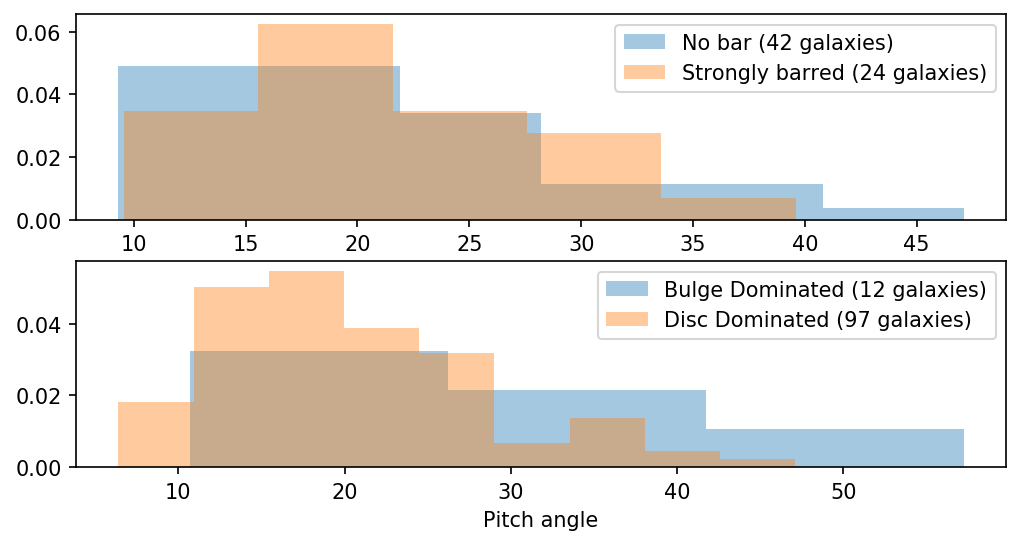

In [32]:
plt.figure(figsize=(8, 4), dpi=150)
plt.subplot(211)
sns.distplot(
    morphology_comparison['phi'][morphology_comparison['No bar']].rename('No bar'),
    label=f'No bar ({n_no_bar} galaxies)',
    kde=False, norm_hist=True,
)
sns.distplot(
    morphology_comparison['phi'][morphology_comparison['Strongly barred']].rename('Bar'),
    label=f'Strongly barred ({n_strong_bar} galaxies)',
    kde=False, norm_hist=True,
)
plt.xlabel('Pitch angle')
plt.legend()

plt.subplot(212)
sns.distplot(
    morphology_comparison['phi'][
        morphology_comparison['GZ2 bulge dominated']
    ],
    label=f'Bulge Dominated ({n_bulge_dominated} galaxies)',
    kde=False, norm_hist=True,
)
sns.distplot(
    morphology_comparison['phi'][
        np.logical_not(morphology_comparison['GZ2 bulge dominated'])
    ],
    label=f'Disc Dominated ({n_disc_dominated} galaxies)',
    kde=False, norm_hist=True,
)
plt.xlabel('Pitch angle')
plt.legend()

The correlation matrix below shows weak links between morphology and pitch angle, as does the density plot from the trace

In [33]:
corr_df = morphology_comparison.drop(columns=['No bar', 'Strongly barred', 'GZ2 bulge dominated']).corr(method='kendall')
corr_df.style.apply(set_color_by_correlation)

,bar fraction,bulge fraction,phi,sd,n
bar fraction,1,0.0603445,0.0280445,0.000509901,0.0443609
bulge fraction,0.0603445,1,0.0261728,-0.0646521,0.214884
phi,0.0280445,0.0261728,1,0.075773,0.295794
sd,0.000509901,-0.0646521,0.075773,1,-0.598077
n,0.0443609,0.214884,0.295794,-0.598077,1


We can see a similar lack of correlation using density plots (which encompasses the whole trace rather than just the expectation)

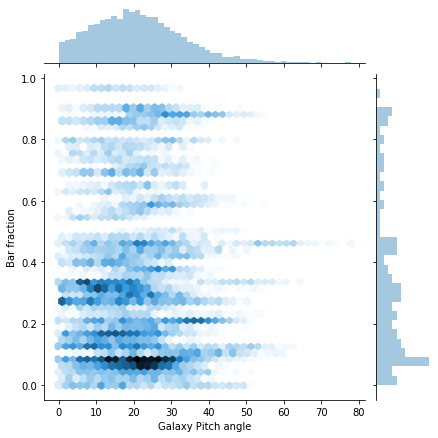

In [34]:
foo = gal_pa_samples.T.sample(100).T
foo = pd.concat((foo, morphology_comparison['bar fraction']), axis=1).values
g = sns.jointplot(foo[:, :-1].ravel(), np.repeat(foo[:, -1], len(foo[0]) - 1), kind='hex')
g.ax_joint.set_xlabel('Galaxy Pitch angle')
g.ax_joint.set_ylabel('Bar fraction')
del foo

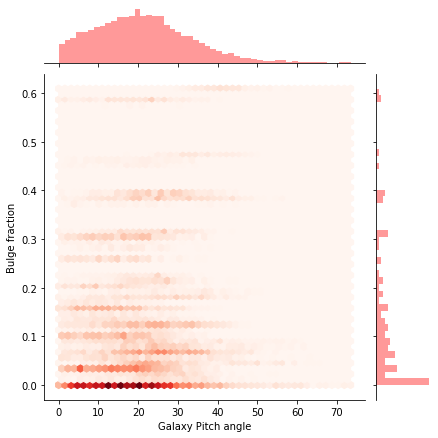

In [35]:
foo = gal_pa_samples.T.sample(100).T
foo = pd.concat((foo, morphology_comparison['bulge fraction']), axis=1).values
g = sns.jointplot(foo[:, :-1].ravel(), np.repeat(foo[:, -1], len(foo[0]) - 1), kind='hex', cmap='Reds', marginal_kws=dict(color='red'))
g.ax_joint.set_xlabel('Galaxy Pitch angle')
g.ax_joint.set_ylabel('Bulge fraction')
del foo

We'll do more marginalized Anderson-Darling tests to determine if the pitch angles of galaxies with our morphological selections are drawn from different distributions (null hypothesis being that they are drawn from the same distribution).

In [36]:
# Test against cot-uniform
anderson_bulge = pd.Series([], name='anderson_test_result')
anderson_bar = pd.Series([], name='anderson_test_result')


with tqdm(gal_pa_samples.T.iterrows(), total=gal_pa_samples.shape[1]) as bar:
    for i, phi_gal_est in bar:
        anderson_bar[i] = st.anderson_ksamp((
            phi_gal_est[morphology_comparison['No bar']].rename('No bar'),
            phi_gal_est[morphology_comparison['Strongly barred']].rename('Bar'),
        ))
        anderson_bulge[i] = st.anderson_ksamp((
            phi_gal_est[morphology_comparison['GZ2 bulge dominated']],
            phi_gal_est[np.logical_not(morphology_comparison['GZ2 bulge dominated'])]
        ))

anderson_bulge = anderson_bulge.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})
anderson_bar = anderson_bar.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

100%|██████████| 4000/4000 [00:59<00:00, 67.16it/s]


Bulge strength Thresholds:
       25%: 0.33, reject 90% of the time
       10%: 1.23, reject 64% of the time
        5%: 1.96, reject 41% of the time
      2.5%: 2.72, reject 22% of the time
        1%: 3.75, reject 8% of the time
Bar strength Thresholds:
       25%: 0.33, reject 11% of the time
       10%: 1.23, reject 2% of the time
        5%: 1.96, reject 1% of the time
      2.5%: 2.72, reject 0% of the time
        1%: 3.75, reject 0% of the time


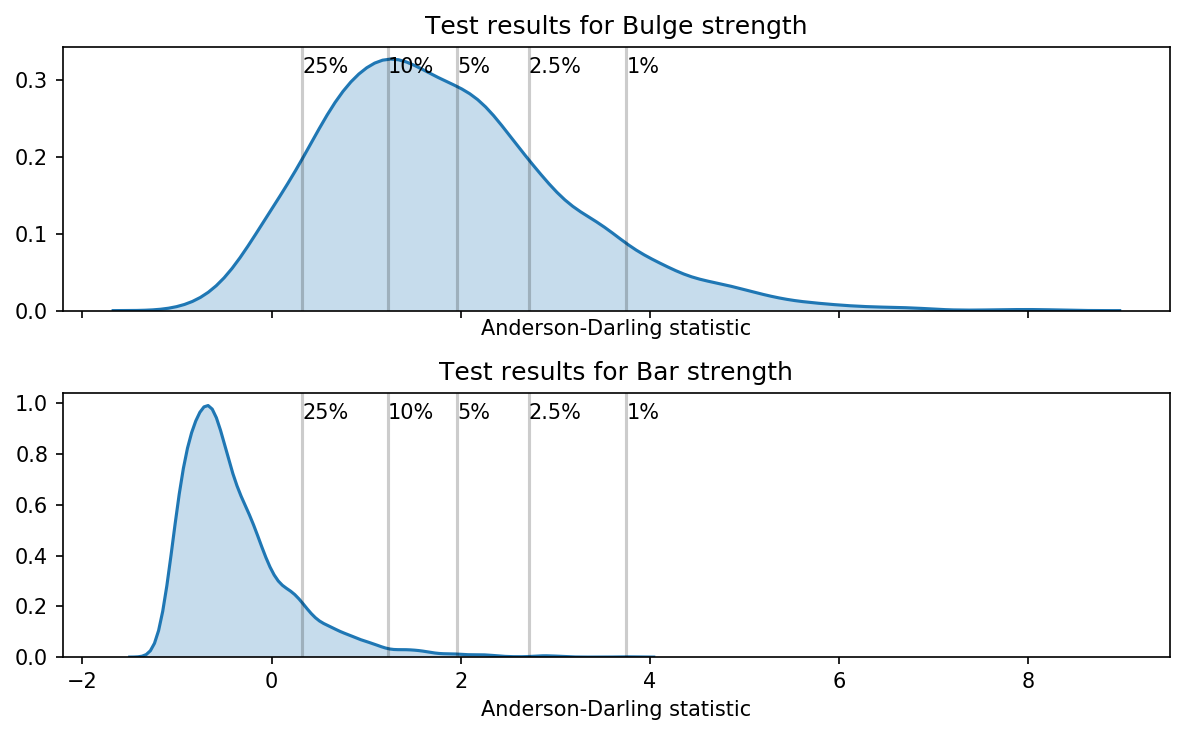

In [53]:
f, ax = plt.subplots(sharex=True, nrows=2, figsize=(8, 5), dpi=150)
plt.sca(ax[0])
plt.title('Test results for Bulge strength')
sns.kdeplot(anderson_bulge['value'], label='', shade=True)
print('Bulge strength Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%'),
    np.stack(anderson_bulge['levels'].values).mean(axis=0)
):
    freq = (anderson_bulge['value'] >= j).sum() / len(anderson_bulge['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.sca(ax[1])
plt.title('Test results for Bar strength')
sns.kdeplot(anderson_bar['value'], label='', shade=True)
print('Bar strength Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%'),
    np.stack(anderson_bar['levels'].values).mean(axis=0)
):
    freq = (anderson_bar['value'] >= j).sum() / len(anderson_bar['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.tight_layout()
plt.savefig('plots/bulge_bar_test_results.pdf', bbox_inches='tight')

So, to answer our question: we do not see evidence for a correlation between pitch angle and bulge or bar strength, and there is insufficient evidence to conclude that there is any difference between the pitch angle distributions of unbarred vs strongly barred galaxies or disc-dominated vs obvious-bulge galaxies.